# <span style="color:skyblue;"> Transformer를 활용해 한/영 번역기 만들기</span>

Korean-English 사이 번역 데이터 corpus를 활용하여 번역 태스크를 수행

데이터 출처 : [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

<span style='color:skyblue;'> **모델 : Vaswani 스타일의 Encoder-Decoder Transformer**</span>

각 시행은 노트북이 진행되면서 밑에 하단부에 기록함. 메인 코드는 "코드 2차" 이지만, 각 세부 설명은 코드 1차를 ㅊ

## <span style="color:skyblue;"> 최종 My Best Pick!! </span>
___ 

Model Hyperparameter: 

`config = {
    "n_layers": 3,
    "d_model": 256,
    "n_heads": 4,
    "d_ff": 1024,
    "dropout": 0.5,
    "src_vocab_size": SRC_VOCAB_SIZE,
    "tgt_vocab_size": TGT_VOCAB_SIZE,
    "pos_len": 50,
    "batch_size": 64,
    "epochs": 7
}`

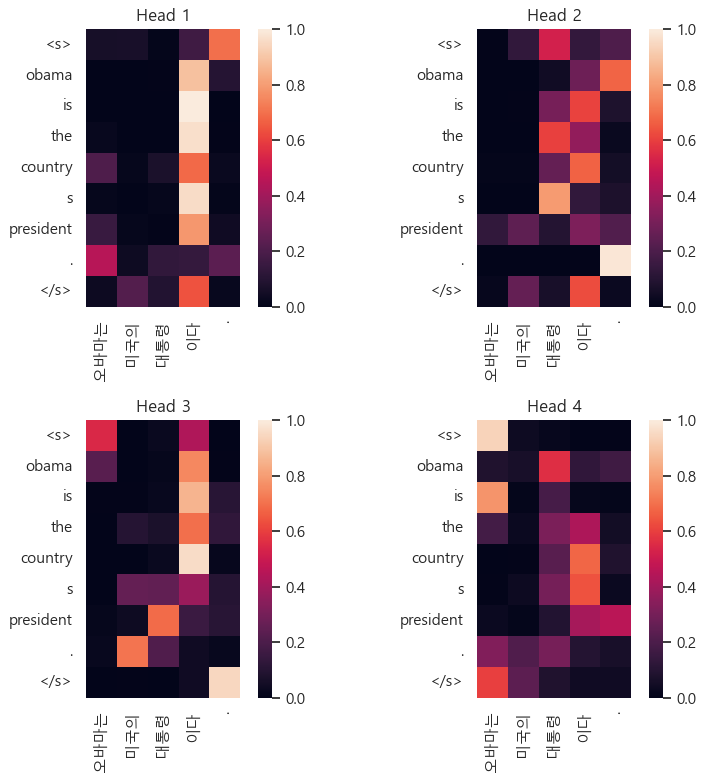

### 훈련 진행 Loss curve: Overfitting은 일단 너무 깊게 걱정하진 말아보자.

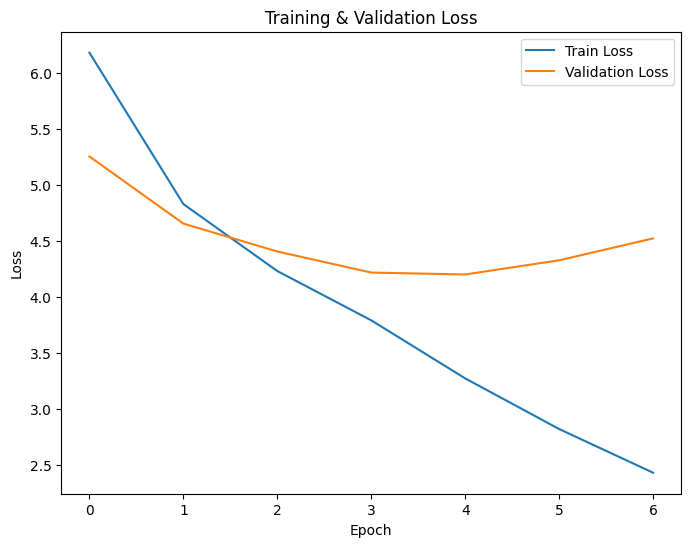


### 예문 출력 결과

Input: 오바마는 미국의 대통령이다.

Predicted translation: `<s>` obama is the country s president . `</s>`

Input: 사람들은 도시에 살고 있다.

Predicted translation: `<s>` people live in the city . `</s>`

Input: 그 것은 필요 없다.

Predicted translation: `<s>` it is not needed . `</s>`

Input: 사고로 다수의 사망자가 발생했다.

Predicted translation: `<s>` a number of dead were in a bomb . `</s>`


### <span style='color:skyblue;'> 실험 간 이슈: 모든 이슈는 SentencePiece 토크나이징 할 때 + U+2581 '▁' 을 필터 아웃 하면서 해결함 </span>

1. `<start>` 토큰이 두 번 나옴 &rightarrow; 그냥 첫 번째 꺼 명시적으로 없앰
- 물론, 왜 두 번 나오는지는 알아야했음. 각 토큰 생성 과정을 보니, 현재 `<start>` 토큰을 인풋으로 번역을 시작하는데 SentencePiece에서 _ 이랑 `<start>`를 별개로 인식하고 있고 그 과정에서 이슈가 생긴듯. 그래서 한 번 더 출력하는 거.. end 토큰에서도 마찬가지 일이 일어나긴 함

2. mask 길이가 안 맞음: 디코더 셀프 어텐션이랑 인코더-디코더 어텐션을 잘 못 줬음
3. 어텐션 플롯에서 한글 폰트가 깨짐 == 해결 불가. 걍 이상함 &rightarrow; 일단 한글을 제거하고 그냥 0,1,2,3... 인덱스로 하자

___
#### 중대이슈: SentencePiece의 토크나이징 문제?

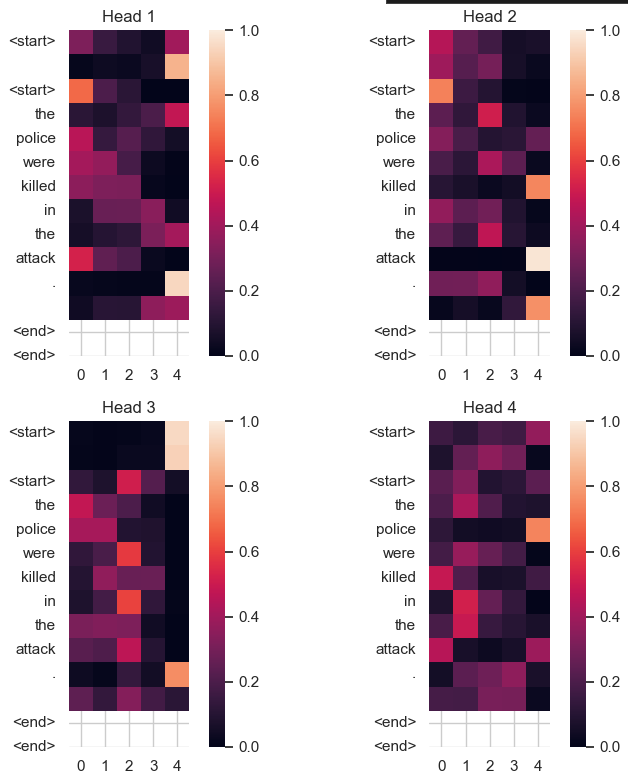

sentencepiece의 lower bar가 분리된 거 같아..
이게 무슨 말이냐,

전처리부터 깔끔하게 해서 sentencepiece가 이슈를 만들지 않도록 해야 한다는거지

난 데이터로 돌아가야만 한다.

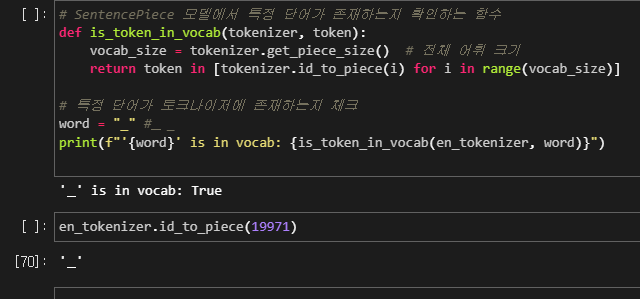

대체 넌 무어냐 .. 

### <span style='color:red;'> 원인 발견 : `"<"`이랑 `>"`토큰을 처리하지를 못하고 있음</span>
        
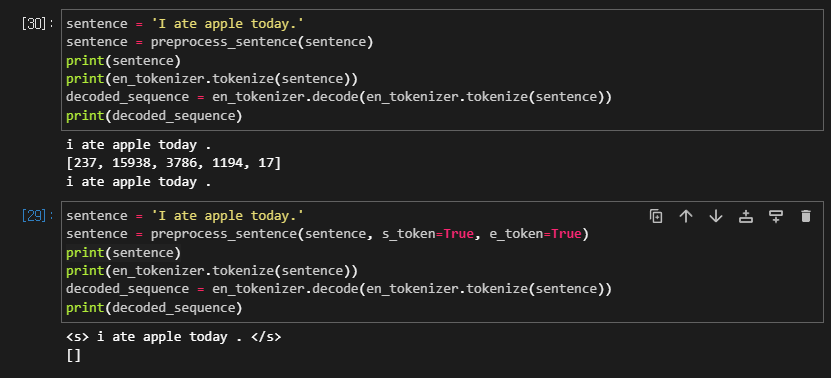
    
이게 말이 되는 현상인가 싶긴한데 나한테 주어진 현실이다 .. 걍 어이가 없음 ㅋㅋ
    
### <span style='color:red;'>해결: user_defined_symbols에 `<s>, </s>, ` 추가하기</span>
    
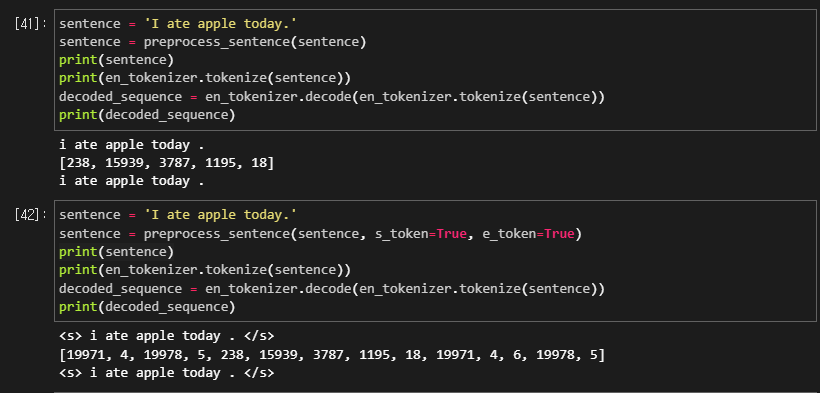
    
이 경우에 있어서 eos_id랑 bos_id가 둘 다 -1로 이상하게 잡히는 문제가 있긴 한데,

여전히 토큰 자체는 id=1,2 번에 bos랑 eos 잡혀 있어서 그냥 직접 하드코딩으로 불러주면 됨

## 코딩 2차.

컴팩트하게 갈 것

### 데이터 준비과정
1. 라이브러리 로드
2. 전처리 및 SentencePiece 토크나이저
3. 패딩

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re
import os
import io
import time
import random
import seaborn as sns
import math

import sentencepiece as spm ### 토크나이징 

from tqdm.notebook import tqdm

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='white')

In [2]:
filepath = 'C:/datasets_temp/korean-parallel-corpora-master/korean-english-news-v1/korean-english-park'

ko_train_path = filepath + '.train-ko.txt'
en_train_path = filepath + '.train-en.txt'
ko_test_path = filepath + '.test-ko.txt'
en_test_path = filepath + '.test-en.txt'

ko_train = open(ko_train_path, 'r', encoding='utf-8').readlines()
en_train = open(en_train_path, 'r', encoding='utf-8').readlines()
ko_test = open(ko_test_path, 'r', encoding='utf-8').readlines()
en_test = open(en_test_path, 'r', encoding='utf-8').readlines()

# 중복 방지는 한-영 페어가 모두 중복인 경우만.
train = [(ko_train[x], en_train[x]) for x in range(len(ko_train))]
test = [(ko_test[x], en_test[x]) for x in range(len(ko_test))]

train = list(set(train))
test = list(set(test))

ko_train, en_train = zip(*train)
ko_test, en_test = zip(*test)

ko_train = list(ko_train)
en_train = list(en_train)
ko_test = list(ko_test)
en_test = list(en_test)

In [3]:
def preprocess_sentence(sentence, s_token=False, e_token=False):   
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9()?.!\s]+", " ", sentence)

    sentence = " ".join(sentence.split())

    if s_token:
        sentence = "<s> " + sentence
    if e_token:
        sentence += " </s>"

    return sentence

ko_train = [preprocess_sentence(x) for x in ko_train]
en_train = [preprocess_sentence(x, s_token=True, e_token=True) for x in en_train]

ko_test = [preprocess_sentence(x) for x in ko_test]
en_test = [preprocess_sentence(x, s_token=True, e_token=True) for x in en_test]

In [4]:
def generate_tokenizer(corpus,
                      vocab_size=20000,
                      lang='ko',
                      pad_id=0,
                      bos_id=1,
                      eos_id=2,
                      unk_id=3):
    
    spm.SentencePieceTrainer.train(
        sentence_iterator = iter(corpus),
        model_prefix=lang,
        vocab_size=vocab_size,
        model_type='bpe',
        pad_id=pad_id,
        pad_piece="<pad>",
        bos_id=bos_id,
        bos_piece="<s>",
        eos_id=eos_id,
        eos_piece="</s>",
        unk_id=unk_id,
        unk_piece="<unk>",
        user_defined_symbols=["<s>", "</s>"]
    )
#user_defined_symbols=["<", ">", "/"]
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(f"{lang}.model")
    
    return tokenizer

In [5]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

# 한국어 & 영어 학습 토크나이저
ko_tokenizer = generate_tokenizer(ko_train, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(en_train, TGT_VOCAB_SIZE, "en")

In [6]:
def check_indices(tokenizer, num_indices=4):
    print("Checking first", num_indices, "indices")
    for i in range(num_indices):
        token = tokenizer.id_to_piece(i)
        print(f"ID {i}: {token}")

check_indices(ko_tokenizer, 10)
check_indices(en_tokenizer, 10)

Checking first 10 indices
ID 0: <pad>
ID 1: <s>
ID 2: </s>
ID 3: <unk>
ID 4: ▁.
ID 5: ▁이
ID 6: 했다
ID 7: ▁있
ID 8: ▁대
ID 9: 에서
Checking first 10 indices
ID 0: <pad>
ID 1: <s>
ID 2: </s>
ID 3: <unk>
ID 4: ▁t
ID 5: ▁a
ID 6: he
ID 7: in
ID 8: ▁s
ID 9: ▁the


In [7]:
sentence = preprocess_sentence('i ate apple today.', s_token=False, e_token=False)
print(sentence)
print(en_tokenizer.tokenize(sentence))
print(en_tokenizer.decode(en_tokenizer.tokenize(sentence)))

i ate apple today .
[237, 16207, 3847, 1219, 14]
i ate apple today .


In [8]:
sentence = preprocess_sentence('i ate apple today.', s_token=True, e_token=True)
print(sentence)
print(en_tokenizer.tokenize(sentence))
print(en_tokenizer.decode(en_tokenizer.tokenize(sentence)))

<s> i ate apple today . </s>
[19961, 1, 237, 16207, 3847, 1219, 14, 19961, 2]
<s> i ate apple today . </s>


In [9]:
# 학습 데이터 (ko_train / en_train) 처리
train_ko_corpus = []
train_en_corpus = []

for i in tqdm(range(len(ko_train))):
    ko_tokens = ko_tokenizer.tokenize(ko_train[i])
    en_tokens = en_tokenizer.tokenize(en_train[i])
    
    train_ko_corpus.append(ko_tokens)
    train_en_corpus.append(en_tokens)
    

  0%|          | 0/78968 [00:00<?, ?it/s]

In [10]:
ko_length = [len(x) for x in train_ko_corpus]
en_length = [len(x) for x in train_en_corpus]

N=50

temp_indices = [i for i in range(len(train_ko_corpus)) if ko_length[i] <= N and en_length[i] <= N]

kor_corpus = [train_ko_corpus[i] for i in temp_indices]
eng_corpus = [train_en_corpus[i] for i in temp_indices]

In [11]:
# 패딩 처리 → enc_train, dec_train
enc_train = tf.keras.preprocessing.sequence.pad_sequences(train_ko_corpus, maxlen=N, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(train_en_corpus, maxlen=N, padding='post')

print("enc_train shape:", enc_train.shape)
print("dec_train shape:", dec_train.shape)

enc_train shape: (78968, 50)
dec_train shape: (78968, 50)


In [12]:
test_ko_corpus = []
test_en_corpus = []

for i in tqdm(range(len(ko_test))):
    ko_tokens = ko_tokenizer.encode_as_ids(ko_test[i])
    en_tokens = en_tokenizer.encode_as_ids(en_test[i])

    test_ko_corpus.append(ko_tokens)
    test_en_corpus.append(en_tokens)
    
ko_test_length = [len(x) for x in test_ko_corpus]
en_test_length = [len(x) for x in test_en_corpus]

N=50

temp_indices = [i for i in range(len(test_ko_corpus)) if ko_length[i] <= N and en_length[i] <= N]

kor_corpus = [test_ko_corpus[i] for i in temp_indices]
eng_corpus = [test_en_corpus[i] for i in temp_indices]    
    
enc_test = tf.keras.preprocessing.sequence.pad_sequences(test_ko_corpus, maxlen=N, padding='post')
dec_test = tf.keras.preprocessing.sequence.pad_sequences(test_en_corpus, maxlen=N, padding='post')

print("enc_test shape:", enc_test.shape)
print("dec_test shape:", dec_test.shape)


  0%|          | 0/1996 [00:00<?, ?it/s]

enc_test shape: (1996, 50)
dec_test shape: (1996, 50)


In [13]:
del ko_train, en_train, ko_test, en_test, train, test, check_indices, ko_length, en_length, temp_indices, kor_corpus, eng_corpus, 

### 트랜스포머 모델 준비
1. 포지셔널 인코딩, 멀티헤드 어텐션, 피드포워드 네트워크 준비
2. 인코더, 디코더 레이어 준비
3. 인코더, 디코더 및 트랜스포머 클래스 구현
4. 마스킹 구현
5. 손실함수, 옵티마이저 등의 베이스 컨피그
6. Train, Test 스텝 정의

In [14]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [15]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        scaled_qk = tf.matmul(Q, K, transpose_b=True) / tf.math.sqrt(d_k)

        if mask is not None: 
            scaled_qk += (mask * -1e9) 

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions

    def split_heads(self, x):
        
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0,2,1,3])

        return split_x

    def combine_heads(self, x):
        
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0,2,1,3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))
        
        return combined_x
    

    def call(self, Q, K, V, mask):
        
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_split = self.split_heads(WQ)
        WK_split = self.split_heads(WK)
        WV_split = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(WQ_split, WK_split, WV_split, mask)
        
        out = self.combine_heads(out)
        
        out = self.linear(out)
        
        return out, attention_weights

In [16]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [17]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Encoder Multi-Head Attention
        플로우: x -> LayerNorm -> MultiHeadAttention -> Dropout -> Add
        
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        플로우: -> LayerNorm -> FFN -> Dropout -> Add
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [18]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.masked_self_attn = MultiHeadAttention(d_model, n_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        플로우: x -> LayerNorm -> Causality-Masked Self MultiHeadAttention -> Dropout -> Add
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.masked_self_attn(out, out, out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Encoder-Decoder Multi-Head Attention
        플로우: -> LayerNorm -> Encoder-Decoder MultiHeadAttention -> Dropout -> Add
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        플로우: -> LayerNorm -> FFN -> Dropout -> Add        
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, dec_attn, dec_enc_attn

In [19]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [20]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [21]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len=50,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_embedding = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_embedding = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        
        self.pos_encoding = positional_encoding(pos_len, d_model)
        
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        self.output_linear = tf.keras.layers.Dense(tgt_vocab_size)
        
        self.shared = shared
        if shared:
            self.output_linear.set_weights(tf.transpose(self.dec_embedding.weights))
            
        self.dropout = tf.keras.layers.Dropout(dropout)

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)
        
        if self.shared:
            out *= tf.math.sqrt(self.d_model)
            
        out += self.pos_encoding[np.newaxis, ...][:,:seq_len, :]
        
        ## 드랍아웃 추가
        out = self.dropout(out)
        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_mask, dec_enc_mask):
        """
        1. 인코더-디코더 구성
        2. 인코더에서 output과 attention 계산 후 디코더에 넘김
        3. 디코더에서 masked self attention과 encoder-decoder multihead attention 계산
        4. FFN
        """
        enc_in_emb = self.embedding(self.enc_embedding, enc_in)
        dec_in_emb = self.embedding(self.dec_embedding, dec_in)
        
        enc_output, enc_attns = self.encoder(enc_in_emb, enc_mask)
        
        dec_output, dec_attns, dec_enc_attns = self.decoder(dec_in_emb, enc_output, dec_mask, dec_enc_mask)
        
        logits = self.output_linear(dec_output)    
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [22]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_causality_mask(tf.shape(tgt)[1])    
    dec_enc_mask = generate_padding_mask(src)
    return enc_mask, dec_mask, dec_enc_mask

In [23]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [24]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [25]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습 진행
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [26]:
@tf.function()
def test_step(src, tgt, model):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
    loss = loss_function(gold, predictions[:, :-1])
    
    return loss

### 기타 도구 준비

시각화 및 추론

In [77]:
def visualize_attention(src, tgt, dec_enc_attns):
    src = [token.replace('▁', '') for token in src if token.replace('▁', '') != '']
    tgt = [token.replace('▁', '') for token in tgt if token.replace('▁', '') != '']
    num_layers = len(dec_enc_attns)  # Transformer 디코더 레이어 개수

    num_heads = dec_enc_attns[num_layers-1][0].shape[1]
    grid_size = math.ceil(math.sqrt(num_heads))
    
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(grid_size * 4, grid_size * 4))

    for h in range(num_heads):
        row, col = divmod(h, grid_size)
        sns.heatmap(
            dec_enc_attns[num_layers-1][0][0, h, :len(tgt), :len(src)], 
            square=True, vmin=0.0, vmax=1.0, cbar=True, ax=axs[row, col],
            xticklabels=src, yticklabels=tgt)
        axs[row, col].set_title(f"Head {h+1}")
           

    # 빈 서브플롯 제거 (num_heads보다 많은 subplot이 생길 경우)
    for h in range(num_heads, grid_size * grid_size):
        fig.delaxes(axs.flatten()[h])

    plt.tight_layout()
    plt.show()


In [28]:
def evaluate(sentence, model):
    """
    1. 입력 문장 전처리 및 토크나이징, 패딩 해서 인코더에 넣을 준비
    """
    sentence = preprocess_sentence(sentence)
    sentence_tokens = ko_tokenizer.encode_as_ids(sentence)
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(
        [sentence_tokens], maxlen=enc_train.shape[-1], padding='post'
    )

    """
    2. 디코딩 하기 위해서 bos 토큰만 초기값으로 설정
    """
    
    output = tf.expand_dims([1],0)

    # 어텐션 정보를 저장할 리스트 초기화(인코더 디코더만)
    all_dec_enc_attns = []

    for i in range(dec_train.shape[-1]):
        enc_mask, dec_mask, dec_enc_mask = generate_masks(padded_tokens, output)
        predictions, enc_attns, dec_attns, dec_enc_attns = model(
            padded_tokens,
            output,
            enc_mask,
            dec_mask,
            dec_enc_mask
        )

        # 각 반복마다 어텐션 정보를 저장
        all_dec_enc_attns.append(dec_enc_attns)

        predicted_id = tf.argmax(predictions[0, -1]).numpy().item()
        """
        predicted_token = en_tokenizer.id_to_piece(predicted_id)

        print(f"Step {i}: predicted_id = {predicted_id}, token = {predicted_token}")
        """
                   
        # eos token이 예측되면 종료
        if predicted_id == 2:
            output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
            break

        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = en_tokenizer.decode_ids(output.numpy()[0].tolist())

    # 결과 번역과 어텐션 정보를 함께 반환
    return result, all_dec_enc_attns

def translate(sentence, model, plot_attention=False):
    result, dec_enc_attns = evaluate(sentence, model)
    
    print('Input: %s' % sentence)
    print('Predicted translation: {}'.format(result))
    
    if plot_attention:
        pieces = ko_tokenizer.encode_as_pieces(sentence)
        result_tokens = en_tokenizer.encode_as_pieces(result)
        visualize_attention(pieces, result_tokens, dec_enc_attns)


### 시행 1.

In [29]:
config = {
    "n_layers": 3,
    "d_model": 256,
    "n_heads": 4,
    "d_ff": 1024,
    "dropout": 0.5,
    "src_vocab_size": SRC_VOCAB_SIZE,
    "tgt_vocab_size": TGT_VOCAB_SIZE,
    "pos_len": 50,
    "batch_size": 64,
    "epochs": 7
}

In [30]:
transformer = Transformer(n_layers=config["n_layers"],
                          d_model=config["d_model"],
                          n_heads=config["n_heads"],
                          d_ff=config["d_ff"],
                          src_vocab_size=config["src_vocab_size"],
                          tgt_vocab_size=config["tgt_vocab_size"],
                          pos_len=config["pos_len"],
                          dropout=config["dropout"],
                          shared=True)

learning_rate = LearningRateScheduler(config['d_model'])
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [31]:
BATCH_SIZE = config['batch_size']
EPOCHS = config['epochs']

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

# 학습 데이터셋 구성
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = train_dataset.shuffle(buffer_size=len(enc_train)).batch(BATCH_SIZE, drop_remainder=True)

# 테스트 데이터셋 구성
test_dataset = tf.data.Dataset.from_tensor_slices((enc_test, dec_test))
test_dataset = test_dataset.batch(BATCH_SIZE)

train_loss_history = []
val_loss_history = []

for epoch in range(EPOCHS):
    
    # Training Loop
    total_train_loss = 0
    train_steps = 0

    progress_bar = tqdm(train_dataset, desc=f"Epoch {epoch+1} Train", leave=True)
    for src_batch, tgt_batch in progress_bar:
        loss, _, _, _ = train_step(src_batch, tgt_batch, transformer, optimizer)
        
        total_train_loss += loss
        train_steps += 1

        avg_train_loss = total_train_loss / train_steps
        progress_bar.set_postfix({"loss": f"{avg_train_loss:.4f}"})
        
    train_loss_history.append(avg_train_loss.numpy())
    
    # Validation Loop
    total_val_loss = 0
    val_steps = 0
    
    progress_bar_val = tqdm(test_dataset, desc=f"Epoch {epoch+1} Val", leave=True)
    for src_batch, tgt_batch in progress_bar_val:
        loss = test_step(src_batch, tgt_batch, transformer)
        
        total_val_loss += loss
        val_steps += 1
        
        avg_val_loss = total_val_loss / val_steps
        progress_bar_val.set_postfix({"val_loss": f"{avg_val_loss:.4f}"})
        
    val_loss_history.append(avg_val_loss.numpy())
    
    print(f"\nEpoch {epoch+1} - Train Loss: {avg_train_loss:.4f} / Val Loss: {avg_val_loss:.4f}")
    
    for example in examples:
        translate(example, transformer)

Epoch 1 Train:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 1 Val:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 1 - Train Loss: 6.1775 / Val Loss: 5.2520
Input: 오바마는 대통령이다.
Predicted translation: <s> obama is a new president of obama . </s>
Input: 시민들은 도시 속에 산다.
Predicted translation: <s> the united states is a few of the world . </s>
Input: 커피는 필요 없다.
Predicted translation: <s> it is not to do not be . </s>
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: <s> the two people have been killed in the two people and injured . </s>


Epoch 2 Train:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 2 Val:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 2 - Train Loss: 4.8278 / Val Loss: 4.6538
Input: 오바마는 대통령이다.
Predicted translation: <s> obama is now obama s first step in obama . </s>
Input: 시민들은 도시 속에 산다.
Predicted translation: <s> the city of city s city of city city city city city of city city of city city city city of city of city city city of city . </s>
Input: 커피는 필요 없다.
Predicted translation: <s> it is not only a very very very very very very very very well . </s>
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: <s> the violence in the violence </s>


Epoch 3 Train:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 3 Val:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 3 - Train Loss: 4.2305 / Val Loss: 4.4050
Input: 오바마는 대통령이다.
Predicted translation: <s> obama s president elect barack obama is a great president . </s>
Input: 시민들은 도시 속에 산다.
Predicted translation: <s> the city s cities . </s>
Input: 커피는 필요 없다.
Predicted translation: <s> it isn t not enough to stay . </s>
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: <s> seven people were killed in the capital  ⁇  </s>


Epoch 4 Train:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 4 Val:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 4 - Train Loss: 3.7911 / Val Loss: 4.2172
Input: 오바마는 대통령이다.
Predicted translation: <s> obama s presidential candidate is the president s presidential nominee . </s>
Input: 시민들은 도시 속에 산다.
Predicted translation: <s> people are in the city of the city . </s>
Input: 커피는 필요 없다.
Predicted translation: <s> it is not clear . </s>
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: <s> the seven people were killed in the capital of the capital . </s>


Epoch 5 Train:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 5 Val:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 5 - Train Loss: 3.2737 / Val Loss: 4.2003
Input: 오바마는 대통령이다.
Predicted translation: <s> obama is a president elect for the president elect . </s>
Input: 시민들은 도시 속에 산다.
Predicted translation: <s> the city of urbanization is the capital of the city of urbanization . </s>
Input: 커피는 필요 없다.
Predicted translation: <s> there is no coffee . </s>
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: <s> seven people were killed in the blast . </s>


Epoch 6 Train:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 6 Val:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 6 - Train Loss: 2.8220 / Val Loss: 4.3266
Input: 오바마는 대통령이다.
Predicted translation: <s> obama is a business model . </s>
Input: 시민들은 도시 속에 산다.
Predicted translation: <s> citizens in the city . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . city . </s>
Input: 커피는 필요 없다.
Predicted translation: <s> there is no coffee . cup without drinking . </s>
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: <s> seven people were killed in the attack . </s>


Epoch 7 Train:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 7 Val:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 7 - Train Loss: 2.4325 / Val Loss: 4.5220
Input: 오바마는 대통령이다.
Predicted translation: <s> obama is the president elect is a presidential candidate . </s>
Input: 시민들은 도시 속에 산다.
Predicted translation: <s> the mountain road in the city  ⁇  </s>
Input: 커피는 필요 없다.
Predicted translation: <s> there is no coffee . </s>
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: <s> seven died . </s>


In [72]:
examples = [
            "오바마는 미국의 대통령이다.",
            "사람들은 도시에 살고 있다.",
            "그 것은 필요 없다.",
            "사고로 다수의 사망자가 발생했다."
]

for example in examples:
    translate(example, transformer)

Input: 오바마는 미국의 대통령이다.
Predicted translation: <s> obama is the country s president . </s>
Input: 사람들은 도시에 살고 있다.
Predicted translation: <s> people live in the city . </s>
Input: 그 것은 필요 없다.
Predicted translation: <s> it is not needed . </s>
Input: 사고로 다수의 사망자가 발생했다.
Predicted translation: <s> a number of dead were in a bomb . </s>


Input: 오바마는 미국의 대통령이다.
Predicted translation: <s> obama is the country s president . </s>


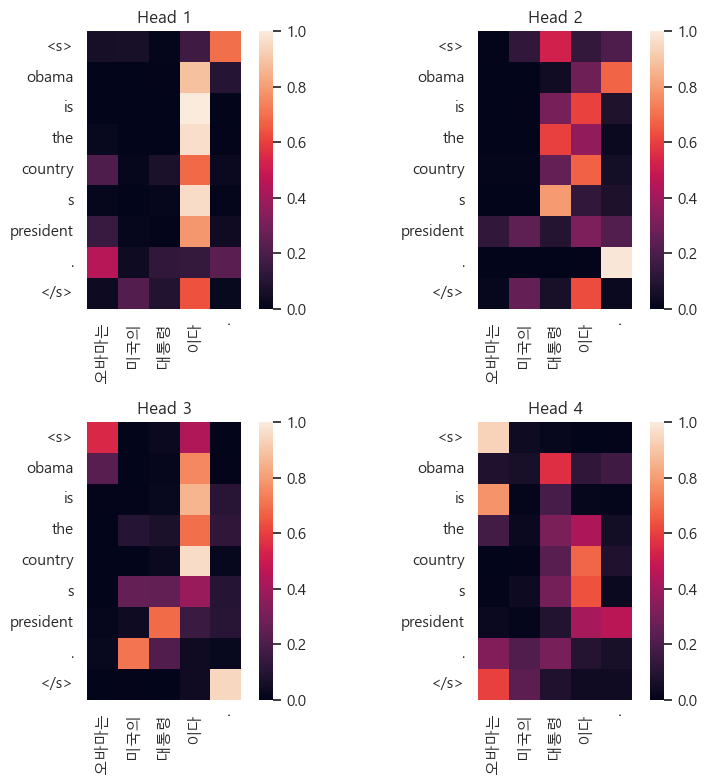

In [78]:
sentence = "오바마는 미국의 대통령이다."
translate(sentence, transformer, plot_attention=True)

In [55]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  5120000   
                                                                 
 embedding_1 (Embedding)     multiple                  5120000   
                                                                 
 encoder (Encoder)           multiple                  2369280   
                                                                 
 decoder (Decoder)           multiple                  3160320   
                                                                 
 dense_48 (Dense)            multiple                  5140000   
                                                                 
 dropout_6 (Dropout)         multiple                  0         
                                                                 
Total params: 20,909,600
Trainable params: 20,909,600
N

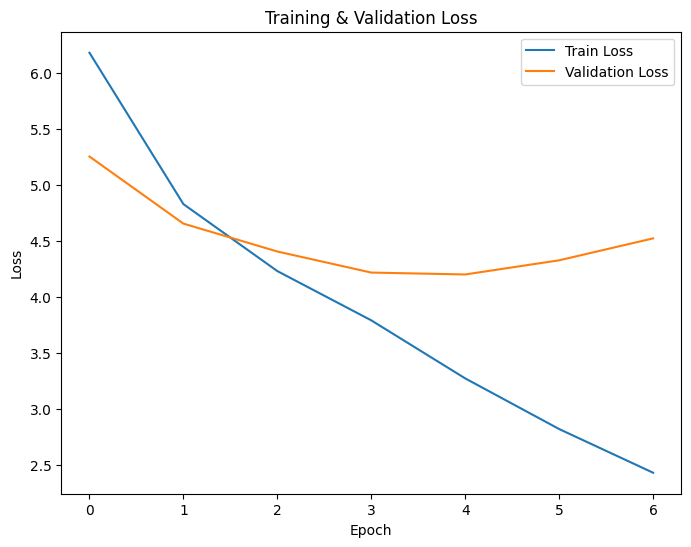

In [34]:
# 마지막에 손실 history 플롯
plt.figure(figsize=(8, 6))
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

## (폐기)코딩 1차.

### 데이터 불러오기 및 기본 전처리

#### 라이브러리 호출

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re
import os
import io
import time
import random
import seaborn as sns

import sentencepiece as spm ### 토크나이징 

from tqdm.notebook import tqdm

In [36]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns

font_path = "C:/Users/양자/AppData/Local/Microsoft/Windows/Fonts/NotoSansCJK-Regular.ttc"

# 폰트 설정
font_prop = fm.FontProperties(fname=font_path)
plt.rc("font", family=font_prop.get_name())

# Seaborn에도 폰트 적용
sns.set(font=font_prop.get_name())
sns.set_style("whitegrid")

def apply_font_to_plot(ax):
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(font_prop)


#### 혼합 정밀도 적용(현재 미적용)

In [37]:
"""
from tensorflow.keras import mixed_precision

# Mixed Precision 설정
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print(policy)
"""

"\nfrom tensorflow.keras import mixed_precision\n\n# Mixed Precision 설정\npolicy = mixed_precision.Policy('mixed_float16')\nmixed_precision.set_global_policy(policy)\n\nprint(policy)\n"

#### 데이터 파일 불러오기

In [38]:
filepath = 'C:/datasets_temp/korean-parallel-corpora-master/korean-english-news-v1/korean-english-park'

ko_train_path = filepath + '.train-ko.txt'
en_train_path = filepath + '.train-en.txt'
ko_test_path = filepath + '.test-ko.txt'
en_test_path = filepath + '.test-en.txt'

ko_train = open(ko_train_path, 'r', encoding='utf-8').readlines()
en_train = open(en_train_path, 'r', encoding='utf-8').readlines()
ko_test = open(ko_test_path, 'r', encoding='utf-8').readlines()
en_test = open(en_test_path, 'r', encoding='utf-8').readlines()

# 중복 방지는 한-영 페어가 모두 중복인 경우만.
train = [(ko_train[x], en_train[x]) for x in range(len(ko_train))]
test = [(ko_test[x], en_test[x]) for x in range(len(ko_test))]

train = list(set(train))
test = list(set(test))

#### Cleaned corpus

In [39]:
ko_train, en_train = zip(*train)
ko_test, en_test = zip(*test)

ko_train = list(ko_train)
en_train = list(en_train)
ko_test = list(ko_test)
en_test = list(en_test)

#### 데이터 전처리

전처리 과정에서 디코딩 할 영문 텍스트는 start 와 end 토큰을 추가

정제 조건:
1. 모든 영문 입력은 소문자로 변환
2. 알파벳, 문장부호, 한글만 남기고 제거
3. 문장부호 양 옆에 공백 추가
4. 문장 앞뒤 불필요한 공백 제거

In [40]:
def preprocess_sentence(sentence, s_token=False, e_token=False):   
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z/<>?.!,\s]+", " ", sentence)

    sentence = " ".join(sentence.split())

    if s_token:
        sentence = "<s> " + sentence
    if e_token:
        sentence += " </s>"

    return sentence

In [41]:
ko_train = [preprocess_sentence(x) for x in ko_train]
en_train = [preprocess_sentence(x, s_token=True, e_token=True) for x in en_train]

ko_test = [preprocess_sentence(x) for x in ko_test]
en_test = [preprocess_sentence(x, s_token=True, e_token=True) for x in en_test]

#### 토크나이징: SentencePiece 활용하기

토크나이징 조건:
1. vocab_size는 유동적으로
2. model file을 SentencePieceProcessor() 클래스에 Load()한 후 반환
3. 특수 토큰의 인덱스를 다음과 같이 지정: `<PAD> : 0 / <BOS> : 1 / <EOS> : 2 / <UNK> : 3`
4. 토큰 길이가 50 이하인 데이터를 선별할 것.

파라미터: 
1. Byte-Pair-Encoding을 채택하여 사용
2. Vocab_size는 20000을 이니셜로 설정


In [42]:
def generate_tokenizer(corpus,
                      vocab_size=20000,
                      lang='ko',
                      pad_id=0,
                      bos_id=1,
                      eos_id=2,
                      unk_id=3):
    
    spm.SentencePieceTrainer.train(
        sentence_iterator = iter(corpus),
        model_prefix=lang,
        vocab_size=vocab_size,
        model_type='bpe',
        pad_id=pad_id,
        bos_id=bos_id,
        eos_id=eos_id,
        unk_id=unk_id,
    )
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(f"{lang}.model")
    
    return tokenizer

In [43]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

# 한국어 & 영어 학습 토크나이저
ko_tokenizer = generate_tokenizer(ko_train, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(en_train, TGT_VOCAB_SIZE, "en")

KeyboardInterrupt: 

#### PAD, SOS, EOS UNK 토큰 확인

Kor:
ID 0: `<pad>`
ID 1: `<start>`
ID 2: `<end>`
ID 3: `<unk>`

Eng:
ID 0: `<pad>`
ID 1: `<start>`
ID 2: `<end>`
ID 3: `<unk>`

In [ ]:
def check_indices(tokenizer, num_indices=4):
    print("Checking first", num_indices, "indices")
    for i in range(num_indices):
        token = tokenizer.id_to_piece(i)
        print(f"ID {i}: {token}")

check_indices(ko_tokenizer, 4)
check_indices(en_tokenizer, 4)

#### 트레인 데이터 토크나이징

In [ ]:
# 학습 데이터 (ko_train / en_train) 처리
train_src_corpus = []
train_tgt_corpus = []

# 길이가 50 이하인 데이터만 선별
N=50

for i in tqdm(range(len(ko_train))):
    ko_tokens = ko_tokenizer.encode_as_ids(ko_train[i])
    en_tokens = en_tokenizer.encode_as_ids(en_train[i])

    # 데이터 선별
    if len(ko_tokens) <= N and len(en_tokens) <= N:
        train_src_corpus.append(ko_tokens)
        train_tgt_corpus.append(en_tokens)

In [ ]:
print(train_src_corpus[0])

In [ ]:
ko_tokenizer.decode(train_src_corpus[0])

In [ ]:
# 패딩 처리 → enc_train, dec_train
enc_train = tf.keras.preprocessing.sequence.pad_sequences(train_src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(train_tgt_corpus, padding='post')

print("enc_train shape:", enc_train.shape)
print("dec_train shape:", dec_train.shape)

#### 테스트 데이터 토크나이징

In [ ]:
test_src_corpus = []
test_tgt_corpus = []

# 길이가 50 이하인 데이터만 선별
N=50

for i in tqdm(range(len(ko_test))):
    ko_tokens = ko_tokenizer.encode_as_ids(ko_test[i])
    en_tokens = en_tokenizer.encode_as_ids(en_test[i])

    # 데이터 선별
    if len(ko_tokens) <= 50 and len(en_tokens) <= 50:
        test_src_corpus.append(ko_tokens)
        test_tgt_corpus.append(en_tokens)

In [ ]:
enc_test = tf.keras.preprocessing.sequence.pad_sequences(test_src_corpus, maxlen=50, padding='post')
dec_test = tf.keras.preprocessing.sequence.pad_sequences(test_tgt_corpus, padding='post')

print("enc_test shape:", enc_test.shape)
print("dec_test shape:", dec_test.shape)


### Encoder-Decoder Transformer 모델 정의하기

#### 포지셔널 인코딩

In [ ]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

#### 멀티헤드 어텐션 클래스

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        scaled_qk = tf.matmul(Q, K, transpose_b=True) / tf.math.sqrt(d_k)

        if mask is not None: 
            scaled_qk += (mask * -1e9) 

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions

    def split_heads(self, x):
        
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0,2,1,3])

        return split_x

    def combine_heads(self, x):
        
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0,2,1,3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))
        
        return combined_x
    

    def call(self, Q, K, V, mask):
        
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_split = self.split_heads(WQ)
        WK_split = self.split_heads(WK)
        WV_split = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(WQ_split, WK_split, WV_split, mask)
        
        out = self.combine_heads(out)
        
        out = self.linear(out)
        
        return out, attention_weights

#### 피드포워드 클래스

In [ ]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

#### 인코더 레이어

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Encoder Multi-Head Attention
        플로우: x -> LayerNorm -> MultiHeadAttention -> Dropout -> Add
        
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        플로우: -> LayerNorm -> FFN -> Dropout -> Add
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

#### 디코더 레이어

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.masked_self_attn = MultiHeadAttention(d_model, n_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        플로우: x -> LayerNorm -> Causality-Masked Self MultiHeadAttention -> Dropout -> Add
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.masked_self_attn(out, out, out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Encoder-Decoder Multi-Head Attention
        플로우: -> LayerNorm -> Encoder-Decoder MultiHeadAttention -> Dropout -> Add
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        플로우: -> LayerNorm -> FFN -> Dropout -> Add        
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, dec_attn, dec_enc_attn

#### 인코더 정의(인코더 레이어 N개)

    d_model의 임베딩 차원의 데이터를  
    dropout 비율 만큼의 Dropout을 갖는  
    n_heads개의 멀티헤드 어텐션과  
    d_ff개의 유닛으로 구성된 FFN으로 구성된 인코더 레이어를 
    n_layers 만큼 반복해 쌓아 구성


In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

#### 디코더 정의(디코더 레이어 N개)

    d_model의 임베딩 차원의 데이터를  
    dropout 비율 만큼의 Dropout을 갖는  
    n_heads개의 멀티헤드 어텐션과  
    d_ff개의 유닛으로 구성된 FFN으로 구성된 인코더 레이어를 
    n_layers 만큼 반복해 쌓아 구성


In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

#### 인코더-디코더 트랜스포머 클래스 정의

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len=50,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_embedding = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_embedding = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        
        self.pos_encoding = positional_encoding(pos_len, d_model)
        
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        self.output_linear = tf.keras.layers.Dense(tgt_vocab_size)
        
        self.shared = shared
        if shared:
            self.output_linear.set_weights(tf.transpose(self.dec_embedding.weights))
            
        self.dropout = tf.keras.layers.Dropout(dropout)

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)
        
        if self.shared:
            out *= tf.math.sqrt(self.d_model)
            
        out += self.pos_encoding[np.newaxis, ...][:,:seq_len, :]
        
        ## 드랍아웃 추가
        out = self.dropout(out)
        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_mask, dec_enc_mask):
        """
        1. 인코더-디코더 구성
        2. 인코더에서 output과 attention 계산 후 디코더에 넘김
        3. 디코더에서 masked self attention과 encoder-decoder multihead attention 계산
        4. FFN
        """
        enc_in_emb = self.embedding(self.enc_embedding, enc_in)
        dec_in_emb = self.embedding(self.dec_embedding, dec_in)
        
        enc_output, enc_attns = self.encoder(enc_in_emb, enc_mask)
        
        dec_output, dec_attns, dec_enc_attns = self.decoder(dec_in_emb, enc_output, dec_mask, dec_enc_mask)
        
        logits = self.output_linear(dec_output)    
        
        return logits, enc_attns, dec_attns, dec_enc_attns

#### 마스크 생성 함수

In [ ]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_causality_mask(tf.shape(tgt)[1])    
    dec_enc_mask = generate_padding_mask(src)
    return enc_mask, dec_mask, dec_enc_mask

#### Learning Rate Scheduler 정의

In [ ]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

#### Loss(Crossentropy) 정의

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

#### Train step 정의

In [ ]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습 진행
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

#### Test step 정의

In [ ]:
@tf.function()
def test_step(src, tgt, model):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
    loss = loss_function(gold, predictions[:, :-1])
    
    return loss

#### 어텐션 시각화 정의

In [ ]:
"""def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        sns.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax, xticklabels=x, yticklabels=y)

    for layer in range(len(dec_enc_attns)):
        print(f"Decoder-Encoder Attention Layer {layer + 1}")
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()
        """

In [ ]:
import math
import seaborn as sns

def visualize_attention(src, tgt, dec_enc_attns):
    """
    모든 Decoder-Encoder Attention Head를 하나의 서브플롯으로 시각화하는 함수
    """
    num_layers = len(dec_enc_attns)  # Transformer 디코더 레이어 개수

    num_heads = dec_enc_attns[num_layers-1][0].shape[1]
    grid_size = math.ceil(math.sqrt(num_heads))
    
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(grid_size * 4, grid_size * 4))

    for h in range(num_heads):
        row, col = divmod(h, grid_size)
        sns.heatmap(
            dec_enc_attns[num_layers-1][0][0, h, :len(tgt), :len(src)], 
            square=True, vmin=0.0, vmax=1.0, cbar=True, ax=axs[row, col],
            xticklabels=range(len(src)), yticklabels=tgt)
        axs[row, col].set_title(f"Head {h+1}")
           

    # 빈 서브플롯 제거 (num_heads보다 많은 subplot이 생길 경우)
    for h in range(num_heads, grid_size * grid_size):
        fig.delaxes(axs.flatten()[h])

    plt.tight_layout()
    plt.show()


#### 번역 생성 함수

In [ ]:
def evaluate(sentence, model):
    """
    1. 입력 문장 전처리 및 토크나이징, 패딩 해서 인코더에 넣을 준비
    """
    sentence = preprocess_sentence(sentence)
    sentence_tokens = ko_tokenizer.encode_as_ids(sentence)
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(
        [sentence_tokens], maxlen=enc_train.shape[-1], padding='post'
    )

    """
    2. 디코딩 하기 위해서 bos 토큰만 초기값으로 설정
    """
    
    output = tf.expand_dims([en_tokenizer.bos_id()],0)

    # 어텐션 정보를 저장할 리스트 초기화(인코더 디코더만)
    all_dec_enc_attns = []

    for i in range(dec_train.shape[-1]):
        enc_mask, dec_mask, dec_enc_mask = generate_masks(padded_tokens, output)
        predictions, enc_attns, dec_attns, dec_enc_attns = model(
            padded_tokens,
            output,
            enc_mask,
            dec_mask,
            dec_enc_mask
        )

        # 각 반복마다 어텐션 정보를 저장
        all_dec_enc_attns.append(dec_enc_attns)

        predicted_id = tf.argmax(predictions[0, -1]).numpy().item()
        """
        predicted_token = en_tokenizer.id_to_piece(predicted_id)

        print(f"Step {i}: predicted_id = {predicted_id}, token = {predicted_token}")
        """
                   
        # eos token이 예측되면 종료
        if predicted_id == en_tokenizer.bos_id():
            output = tf.concat([output, [[predicted_id]]], axis=-1)
            break

        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    # output 전체 리스트의 id들을 어휘 범위 내로 수정
    output_ids = output.numpy()[0].tolist()
    if output_ids[0] == en_tokenizer.eos_id():
        output_ids = output_ids[1:]

    result = en_tokenizer.decode_ids(output_ids)

    # 결과 번역과 어텐션 정보를 함께 반환
    return result, all_dec_enc_attns

def translate(sentence, model, plot_attention=False):
    result, dec_enc_attns = evaluate(sentence, model)
    
    print('Input: %s' % sentence)
    print('Predicted translation: {}'.format(result))
    
    if plot_attention:
        pieces = ko_tokenizer.encode_as_pieces(sentence)
        result_tokens = en_tokenizer.encode_as_pieces(result)
        visualize_attention(pieces, result_tokens, dec_enc_attns)


def evaluate(sentence, model):
    """
    1. 입력 문장 전처리 및 토크나이징, 패딩 해서 인코더 집어넣을 준비
    """
    
    sentence = preprocess_sentence(sentence)
    sentence_tokens = ko_tokenizer.encode_as_ids(sentence)
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences([sentence_tokens], maxlen=enc_train.shape[-1], padding='post')
    
    """
    2. 디코딩 하기 위해서 bos 토큰만.
    """
    output = tf.expand_dims([en_tokenizer.bos_id()], 0)
    
    for i in range(dec_train.shape[-1]):
        enc_mask, dec_mask, dec_enc_mask = generate_masks(padded_tokens, output)
        
        predictions, enc_attns, dec_attns, dec_enc_attns = model(padded_tokens,
                                                                 output,
                                                                 enc_mask,
                                                                 dec_mask,
                                                                 dec_enc_mask)

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
        
        if predicted_id == en_tokenizer.eos_id():
            break
        
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = en_tokenizer.decode_ids(output.numpy()[0].tolist())

    return result

# 번역 생성 및 어텐션 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    result = evaluate(sentence, model)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

### 시행 1:

LMS 노드 조건: 시행 1인 2 Layers

Vaswani의 경우, 각 헤드가 64차원을 처리하도록 설정했으므로, d_model / n_heads = 64가 되도록 설정해보기

또, Feed forward network의 경우 d_model의 4배로 설정

Hyperparameters:
- n_layers = 4
- d_model = 512
- n_heads = 8
- d_ff = 4 * d_model = 2048
- src_vocab_size = 20000
- tgt_vocab_size = 20000

VRAM 사용량 : 6.6/8.0GB

학습 곡선: 
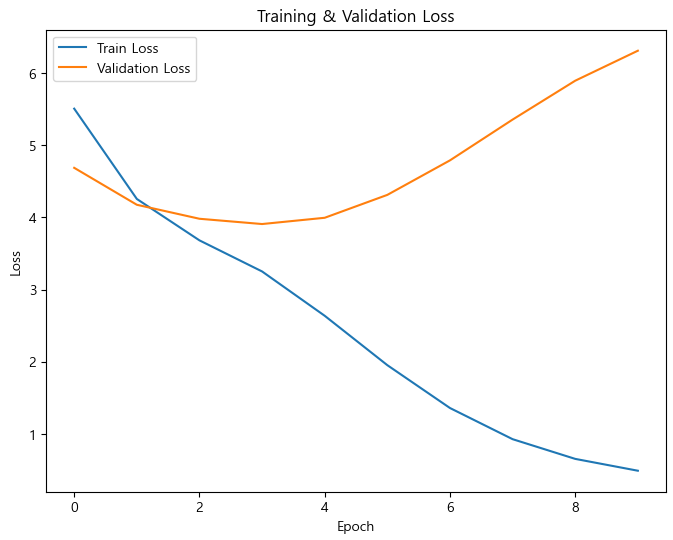

예문 : 

Input: 일곱 명의 사망자가 발생했다.

Predicted translation: `<start> <start> seven people were killed in the wednesday s deaths . <end>`
    
Q. 왜 `<start>` 토큰이 두 번 나타나는가?

### 시행 2:

Hyperparameters 변경사항: 모델 경량화
- n_layers = 2
- d_model = 256
- n_heads = 4
- d_ff = 4 * d_model
- dropout rate = 0.5

VRAM 사용량 : 6.6/8.0GB

학습 곡선: 
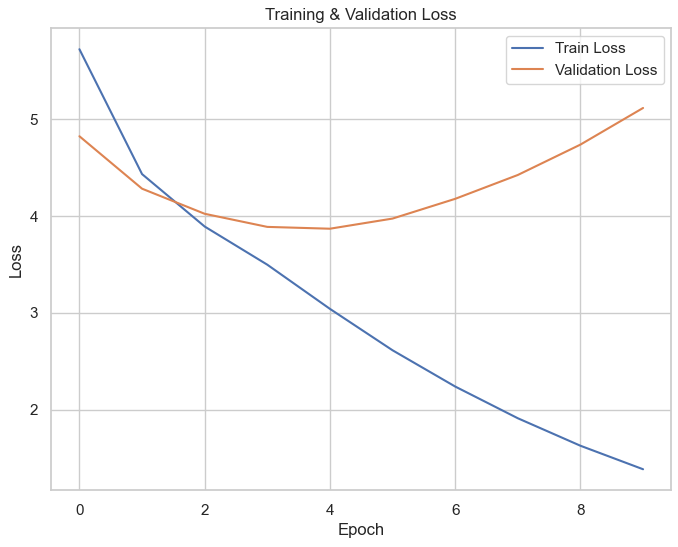

예문 :

Epoch 5: 

`
Input: 오바마는 대통령이다.

Predicted translation: <start> <start> obama s presidential election is a key president . <end>

Input: 시민들은 도시 속에 산다.

Predicted translation: <start> <start> the city s city is in the city of sanjay . <end>

Input: 커피는 필요 없다.

Predicted translation: <start> <start> no problem is that <end>

Input: 일곱 명의 사망자가 발생했다.

Predicted translation: <start> <start> seven people died . <end>

`

Epoch 10 - Train Loss: 1.3830 / Val Loss: 5.1162

`
Input: 오바마는 대통령이다.

Predicted translation: <start> <start> obama is a president . <end>

Input: 시민들은 도시 속에 산다.

Prediced translation: <start> <start> the new cities is the highest in the san francisco cities . <end>

Input: 커피는 필요 없다.

Predicted translation: <start> <start> do not have a new style . <end>

Input: 일곱 명의 사망자가 발생했다.

Predicted translation: <start> <start> seven people died . <end>

`

Q. 대체. 왜. start 토큰이 두 번 나타나는거야 !!! 

### 시행 3:

Hyperparameters 변경사항: 모델 중량화
- n_layers = 6
- d_model = 768
- n_heads = 12
- d_ff = 4 * d_model
- dropout rate = 0.5

VRAM 사용량 : 6.6/8.0GB

학습 곡선: 
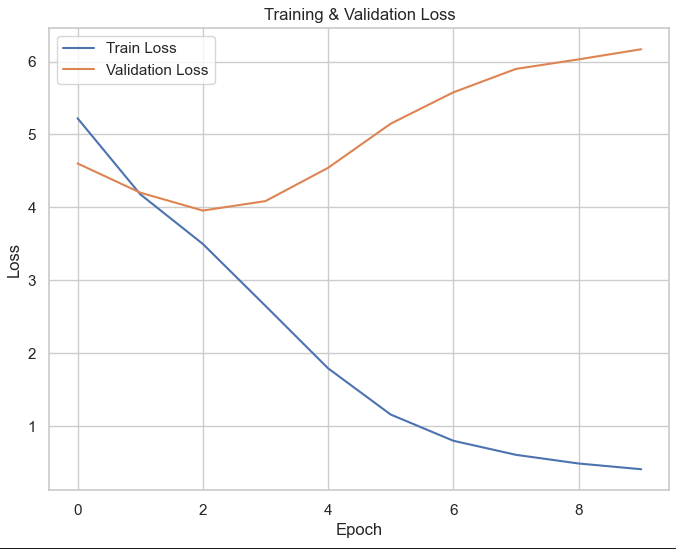

예문 :

Epoch 5: 

`
Input: 오바마는 대통령이다.

Predicted translation: <start> <start> obama s presidential election is a key president . <end>

Input: 시민들은 도시 속에 산다.

Predicted translation: <start> <start> the city s city is in the city of sanjay . <end>

Input: 커피는 필요 없다.

Predicted translation: <start> <start> no problem is that <end>

Input: 일곱 명의 사망자가 발생했다.

Predicted translation: <start> <start> seven people died . <end>

`

Epoch 10 - Train Loss: 0.4093 / Val Loss: 6.1681

`
Input: 오바마는 대통령이다.

Predicted translation: <start> <start> obama is said to have . <end>

Input: 시민들은 도시 속에 산다.

Predicted translation: <start> <start> and the city of medical heavy snow . <end>

Input: 커피는 필요 없다.

Predicted translation: <start> <start> the coffee is needed . <end>

Input: 일곱 명의 사망자가 발생했다.

Predicted translation: <start> <start> seven people were killed . <end>

`

이제는 문제들을 해결할 차례.

#### Config

In [ ]:
config = {
    "n_layers": 2,
    "d_model": 256,
    "n_heads": 4,
    "d_ff": 1024,
    "dropout": 0.5,
    "src_vocab_size": SRC_VOCAB_SIZE,
    "tgt_vocab_size": TGT_VOCAB_SIZE,
    "pos_len": 50,
    "batch_size": 64,
    "epochs": 10
}

In [ ]:
transformer = Transformer(n_layers=config["n_layers"],
                          d_model=config["d_model"],
                          n_heads=config["n_heads"],
                          d_ff=config["d_ff"],
                          src_vocab_size=config["src_vocab_size"],
                          tgt_vocab_size=config["tgt_vocab_size"],
                          pos_len=config["pos_len"],
                          dropout=config["dropout"],
                          shared=True)

learning_rate = LearningRateScheduler(config['d_model'])
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

#### Train loop 시행

In [ ]:
BATCH_SIZE = config['batch_size']
EPOCHS = config['epochs']

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

# 학습 데이터셋 구성
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = train_dataset.shuffle(buffer_size=len(enc_train)).batch(BATCH_SIZE, drop_remainder=True)

# 테스트 데이터셋 구성
test_dataset = tf.data.Dataset.from_tensor_slices((enc_test, dec_test))
test_dataset = test_dataset.batch(BATCH_SIZE)

train_loss_history = []
val_loss_history = []

for epoch in range(EPOCHS):
    
    # Training Loop
    total_train_loss = 0
    train_steps = 0

    progress_bar = tqdm(train_dataset, desc=f"Epoch {epoch+1} Train", leave=True)
    for src_batch, tgt_batch in progress_bar:
        loss, _, _, _ = train_step(src_batch, tgt_batch, transformer, optimizer)
        
        total_train_loss += loss
        train_steps += 1

        avg_train_loss = total_train_loss / train_steps
        progress_bar.set_postfix({"loss": f"{avg_train_loss:.4f}"})
        
    train_loss_history.append(avg_train_loss.numpy())
    
    # Validation Loop
    total_val_loss = 0
    val_steps = 0
    
    progress_bar_val = tqdm(test_dataset, desc=f"Epoch {epoch+1} Val", leave=True)
    for src_batch, tgt_batch in progress_bar_val:
        loss = test_step(src_batch, tgt_batch, transformer)
        
        total_val_loss += loss
        val_steps += 1
        
        avg_val_loss = total_val_loss / val_steps
        progress_bar_val.set_postfix({"val_loss": f"{avg_val_loss:.4f}"})
        
    val_loss_history.append(avg_val_loss.numpy())
    
    print(f"\nEpoch {epoch+1} - Train Loss: {avg_train_loss:.4f} / Val Loss: {avg_val_loss:.4f}")
    
    for example in examples:
        translate(example, transformer)

In [ ]:
transformer.summary()

In [ ]:
# 마지막에 손실 history 플롯
plt.figure(figsize=(8, 6))
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

In [ ]:
sentence = "오바마는 대통령이다."

In [ ]:
translate(sentence, transformer, plot_attention=True)